## Preprocessing logo dataset


In [ ]:
import os
import glob

from lxml import etree as ET

import pandas as pd

from sklearn.model_selection import train_test_split

In [ ]:
dataset_dir = "/kaggle/input/logodet3k/LogoDet-3K"
os.listdir(dataset_dir)

['Leisure',
 'Sports',
 'Necessities',
 'Medical',
 'Electronic',
 'Clothes',
 'Transportation',
 'Food',
 'Others']

In [68]:
df = pd.DataFrame(glob.glob(f"{dataset_dir}/*/*/*"), columns=["file_path"])
df["file_extension"] = df["file_path"].apply(lambda x: x.split(".")[-1])
df["logo_category"] = df["file_path"].apply(lambda x: x.split(os.sep)[-3])
df["logo_name"] = df["file_path"].apply(lambda x: x.split(os.sep)[-2])
df.head()

,file_path,file_extension,logo_category,logo_name
0,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
1,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
2,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
3,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
4,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery


Count number of image and xml available in whole dataset

In [69]:
df["file_extension"].value_counts()

file_extension
jpg    158654
xml    158654
Name: count, dtype: int64

we have equal number of xml and image .. that means we have xml for each image (xml file contains annotation)

In [70]:
df2 = df[df["file_extension"]=="jpg"].iloc[:]

df2["logo_category"].value_counts()

logo_category
Food              53350
Clothes           31266
Necessities       24822
Others            15513
Transportation    10445
Electronic         9675
Leisure            5685
Sports             3953
Medical            3945
Name: count, dtype: int64

In [4]:
classname2idx = {"logo": 0}
idx2classname =  {0:"logo"}
print(idx2classname)



{0: 'logo'}


converting pascal voc annotaation into coco format

In [ ]:
import os
import xml.etree.ElementTree as ET

def convert_voc_to_dict(
    src_xml: str,
    classname2idx: dict,
    image_id
) -> dict:
   
    # 1) load and parse XML
    tree = ET.parse(src_xml)
    root = tree.getroot()
   
    orig_w = float(root.find("size/width").text)
    orig_h = float(root.find("size/height").text)


    categories = []
    annotations = []
    # 2) loop objects
    for idx, obj in enumerate(root.findall("object")):
        cls_name = obj.find("name").text
        cls_idx  = classname2idx.get(cls_name, 0)

        bb = obj.find("bndbox")
        xmin = float(bb.find("xmin").text)  
        ymin = float(bb.find("ymin").text) 
        xmax = float(bb.find("xmax").text) 
        ymax = float(bb.find("ymax").text) 

        w = xmax - xmin
        h = ymax - ymin
        area = w * h
        bboxes=[xmin, ymin, w, h]
        formatted_annotation = {
                "image_id": image_id,
                "category_id": 0,
                "bbox": list(bboxes),
                "iscrowd": 0,
                "area": area
            }
        annotations.append(formatted_annotation)
          


    return {
            "image_id": image_id,
            "annotations": annotations,
        }


Dividing dataset into train and test data ..
80% of data into train set and 20% of data into test set 

In [ ]:
df2['is_train'] = True
train_df, test_df = train_test_split(df2, test_size=0.2, random_state=101)
test_df['is_train'] = False

# combine both train and test set 
final_df = pd.concat([train_df, test_df])
final_df.reset_index(drop=True, inplace=True)


### Generate annotation for each file path present in final dataframe

In [ ]:

def make_annotation(row):
    # only convert if no .txt already exists
    xml_path = row["file_path"].replace(".jpg", ".xml")
    image_id=row.name
    return convert_voc_to_dict(xml_path, classname2idx,image_id)
    

# now create the new column in one go
final_df["annotation"] = final_df.apply(make_annotation, axis=1)


In [ ]:
final_df
final_df.to_csv("logodet--3k.csv", index=False)

In [ ]:
final_df = pd.read_csv("/kaggle/input/logodet/logodet--3k.csv")

In [ ]:
final_df

,file_path,file_extension,logo_category,logo_name,is_train,annotation
0,/kaggle/input/logodet3k/LogoDet-3K/Necessities...,jpg,Necessities,parkay,True,"{'image_id': 0, 'annotations': [{'image_id': 0..."
1,/kaggle/input/logodet3k/LogoDet-3K/Medical/cam...,jpg,Medical,camlin,True,"{'image_id': 1, 'annotations': [{'image_id': 1..."
2,/kaggle/input/logodet3k/LogoDet-3K/Food/sweete...,jpg,Food,sweetened wheat-fuls,True,"{'image_id': 2, 'annotations': [{'image_id': 2..."
3,/kaggle/input/logodet3k/LogoDet-3K/Clothes/Exo...,jpg,Clothes,Exofficio,True,"{'image_id': 3, 'annotations': [{'image_id': 3..."
4,/kaggle/input/logodet3k/LogoDet-3K/Transportat...,jpg,Transportation,maybach-1,True,"{'image_id': 4, 'annotations': [{'image_id': 4..."
...,...,...,...,...,...,...
158649,/kaggle/input/logodet3k/LogoDet-3K/Electronic/...,jpg,Electronic,me too,False,"{'image_id': 158649, 'annotations': [{'image_i..."
158650,/kaggle/input/logodet3k/LogoDet-3K/Clothes/Koo...,jpg,Clothes,KooGa,False,"{'image_id': 158650, 'annotations': [{'image_i..."
158651,/kaggle/input/logodet3k/LogoDet-3K/Transportat...,jpg,Transportation,Landwind-3,False,"{'image_id': 158651, 'annotations': [{'image_i..."
158652,/kaggle/input/logodet3k/LogoDet-3K/Food/Chuck-...,jpg,Food,Chuck-A-Rama,False,"{'image_id': 158652, 'annotations': [{'image_i..."


### Now we have image annotation for each file .Using it converting each image into pixel using image processor

In [ ]:
import numpy as np
from transformers import AutoImageProcessor
checkpoint = "PekingU/rtdetr_v2_r50vd"
image_size = 480

image_processor = AutoImageProcessor.from_pretrained(
    checkpoint,
    do_resize=True,
    size={"width": image_size, "height": image_size},
    use_fast=True,
)

In [ ]:
import albumentations as A

train_augmentation_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category_ids"],    clip=True, min_area=25, min_width=1, min_height=1),
)

# to make sure boxes are clipped to image size and there is no boxes with area < 1 pixel
validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="coco", label_fields=["category_ids"],    clip=True, min_area=1, min_width=1, min_height=1),
)

### Custom class that will take whole dataset and conver it into obejct that contain (pixel values and labels) 

In [ ]:
from torch.utils.data import Dataset
from PIL import Image


class LogoDataset(Dataset):
    def __init__(self, dataset, image_processor, transform=None):
        self.dataset = dataset
        self.image_processor = image_processor
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]

        image_path = sample["file_path"]
        image = Image.open(image_path)
        formatted_annotations = sample["annotation"]

        # Convert image to RGB numpy array
        image = np.array(image.convert("RGB"))

        result = self.image_processor(
            images=image, annotations=formatted_annotations, return_tensors="pt"
        )

        # Image processor expands batch dimension, lets squeeze it
        result = {k: v[0] for k, v in result.items()}

        return result


In [ ]:
train_records =  final_df[ final_df["is_train"]].to_dict("records")
val_records   =  final_df[ final_df["is_train"]==False].to_dict("records")
train_records[0]

{'file_path': '/kaggle/input/logodet3k/LogoDet-3K/Necessities/parkay/115.jpg',
 'file_extension': 'jpg',
 'logo_category': 'Necessities',
 'logo_name': 'parkay',
 'is_train': True,
 'annotation': "{'image_id': 0, 'annotations': [{'image_id': 0, 'category_id': 0, 'bbox': [127.0, 167.0, 239.0, 81.0], 'iscrowd': 0, 'area': 19359.0}]}"}

In [ ]:
train_dataset = LogoDataset(train_records, image_processor, transform=train_augmentation_and_transform)
validation_dataset = LogoDataset(val_records, image_processor, transform=validation_transform)


In [ ]:
import pickle
train_path = "/kaggle/working/train_dataset.pkl"
valid_path = "/kaggle/working/validation_dataset.pkl"
with open(train_path, "wb") as f:
    pickle.dumps(train_dataset)

with open(valid_path, "wb") as f:
    pickle.dumps(validation_dataset)

In [ ]:
from transformers import logging as hf_logging

# suppress everything below ERROR
hf_logging.set_verbosity_error()


In [ ]:
train_dataset[0]

In [ ]:
train_path = "/kaggle/working/train_dataset.pkl"
valid_path = "/kaggle/working/validation_dataset.pkl"

with open(train_path, "rb") as f:
    train = pickle.load(f)

with open(valid_path, "rb") as f:
    valid = pickle.load(f)

Unused or unrecognized kwargs: annotations, masks_path.


Image tensor shape: torch.Size([3, 480, 480])
Boxes shape: (1, 4)
Categories shape: (1,)


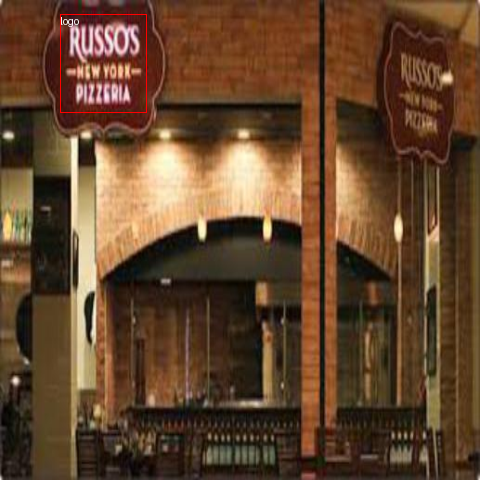

Unused or unrecognized kwargs: annotations, masks_path.


Image tensor shape: torch.Size([3, 480, 480])
Boxes shape: (1, 4)
Categories shape: (1,)


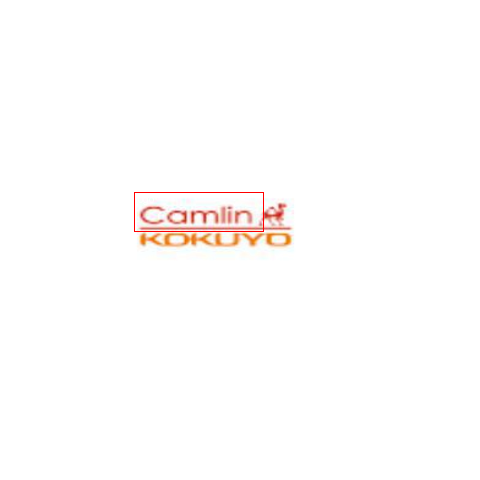

Unused or unrecognized kwargs: annotations, masks_path.


Image tensor shape: torch.Size([3, 480, 480])
Boxes shape: (1, 4)
Categories shape: (1,)


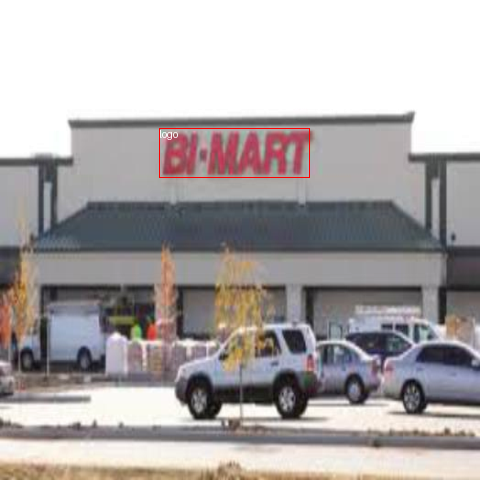

In [ ]:
from PIL import Image, ImageDraw

for i in [15, 1, 17]:
    sample = train[i]

    # De-normalize image
    image = sample["pixel_values"]
    print("Image tensor shape:", image.shape)
    image = image.numpy().transpose(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min()) * 255.
    image = Image.fromarray(image.astype(np.uint8))

    # Convert boxes from [center_x, center_y, width, height] to [x, y, width, height] for visualization
    boxes = sample["labels"]["boxes"].numpy()
    print("Boxes shape:", boxes.shape)
    boxes[:, :2] = boxes[:, :2] - boxes[:, 2:] / 2
    w, h = image.size
    boxes = boxes * np.array([w, h, w, h])[None]

    categories = sample["labels"]["class_labels"].numpy()
    print("Categories shape:", categories.shape)

    # Draw boxes and labels on image
    draw = ImageDraw.Draw(image)
    for box, category in zip(boxes, categories):
        x, y, w, h = box
        draw.rectangle([x, y, x + w, y + h], outline="red", width=1)
        draw.text((x, y), idx2classname[category], fill="white")

    display(image)